General review:

https://genomebiology.biomedcentral.com/articles/10.1186/gb-2003-4-4-210

(doi:10.1186/gb-2003-4-4-210)

## Subtask 0: Download the data

hint:

http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import scipy.stats as sp


In [1]:
!wget -i expression.txt science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx

--2016-09-23 15:06:29--  http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx
Resolving www-cache (www-cache)... 134.2.12.47, 134.2.12.41, 134.2.12.48
Connecting to www-cache (www-cache)|134.2.12.47|:3128... connected.
Proxy request sent, awaiting response... 302 Moved Temporarily
Location: http://science.sciencemag.org/content/sci/suppl/2016/06/10/352.6291.aad0189.DC1/aad0189_DataFileS5.xlsx [following]
--2016-09-23 15:06:30--  http://science.sciencemag.org/content/sci/suppl/2016/06/10/352.6291.aad0189.DC1/aad0189_DataFileS5.xlsx
Reusing existing connection to www-cache:3128.
Proxy request sent, awaiting response... 200 OK
Length: 26159119 (25M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘aad0189_DataFileS5.xlsx’

100%[======================================>] 26,159,119   331KB/s   in 78s    

2016-09-23 15:07:51 (327 KB/s) - ‘aad0189_DataFileS5.xlsx’ saved [26159119/26159119]

expression.tx

## Task 1: Data wrangling

hint:

http://www.arrayanalysis.org/main.html

### Subtask 1.1: Read in aad0189_DataFileS5.xlsx with pandas

In [6]:
expression = pd.read_excel("aad0189_DataFileS5.xlsx",header=2)

In [7]:
exp = expression.copy()

In [8]:
exp.dropna(how='all',inplace=True)
exp.dropna(how='all',inplace=True,axis=1)

### Subtask 1.2: Average over different probesets for a gene and generate a dataframe containing each gene symbol (once)  as rows and the corresponding averaged expression values for each strain + condition as columns

In [9]:
exp = exp.groupby('Gene').mean()

In [10]:
exp

,Original_Order,MATCH_ORDER,Probeset,Range CD,Range HFD,Range_All,C57BL/6J_Liver_CD,DBA/2J_Liver_CD,BXD43_Liver_CD,BXD44_Liver_CD,...,BXD89_Liver_HFD,BXD90_Liver_HFD,BXD95_Liver_HFD,BXD96_Liver_HFD,BXD97_Liver_HFD,BXD98_Liver_HFD,BXD99_Liver_HFD,BXD100_Liver_HFD,BXD101_Liver_HFD,BXD103_Liver_HFD
Gene,,,,,,,,,,,,,,,,,,,,,
39872,31277.000000,NaN,1.057205e+07,2.297397,1.496923,2.297397,7.864000,7.180000,7.067000,7.2650,...,7.538000,7.707000,7.491000,7.923,7.601000,7.7800,7.59700,7.679,7.66600,7.725000
39873,17826.000000,NaN,1.045002e+07,1.458009,1.611049,1.611049,10.778000,10.730000,10.931000,10.7360,...,11.015000,10.983000,10.982000,11.153,11.189000,11.0260,11.05400,11.064,11.00600,10.808000
39874,18766.000000,NaN,1.045898e+07,1.542211,1.588869,1.604362,7.527000,7.754000,7.533000,7.6590,...,7.581000,7.488000,7.554000,7.461,7.592000,7.4250,7.41000,7.539,7.38800,7.334000
39875,7705.000000,NaN,1.035547e+07,1.718322,1.606588,1.772763,6.773000,7.288000,7.289000,6.9290,...,7.307000,7.333000,7.555000,7.098,7.101000,7.0910,7.24600,7.021,7.24600,7.339000
39876,19195.000000,NaN,1.046279e+07,1.593280,1.705270,1.854461,11.095000,11.272000,11.690000,11.5640,...,11.360000,11.447000,11.450000,11.136,11.382000,11.3900,11.56100,11.031,11.18900,11.204000
39877,15506.000000,NaN,1.042802e+07,1.759298,1.596597,1.759298,11.446000,11.605000,11.871000,11.7050,...,11.809000,11.933000,11.986000,11.625,11.749000,11.5640,11.68300,11.726,11.72000,11.943000
39878,20138.000000,NaN,1.047228e+07,1.954772,1.556170,1.954772,9.740000,9.724000,9.849000,9.6440,...,9.784000,9.954000,9.443000,9.902,10.078000,9.7140,9.58500,9.762,9.82800,9.816000
39879,27439.000000,NaN,1.054105e+07,1.688802,1.715941,1.798757,10.364000,10.897000,10.530000,10.6840,...,10.557000,10.709000,10.209000,10.653,10.639000,10.5850,10.62900,10.552,10.38400,10.574000
39880,9539.000000,NaN,1.037302e+07,1.798757,1.669019,1.808759,7.042000,7.405000,7.547000,7.4420,...,6.970000,7.068000,7.494000,7.063,7.121000,7.2300,7.30200,7.535,7.38400,7.340000


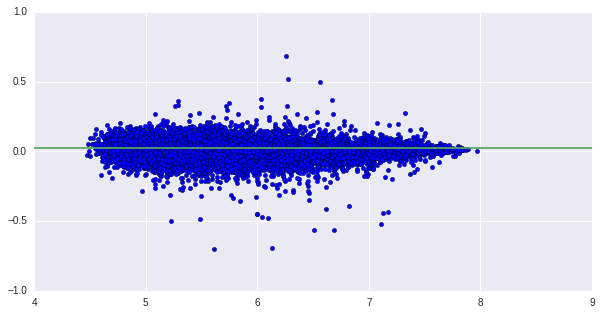

### Subtask 1.3: Quantile normalization: carry out a quantile normalization of the data (or not)

#### Subsubtask 1.3.1: Implement a ratio intensity plot (using matplotlib)

In [8]:
def plotRI(df,col1,col2):
    e1 = df[col1]
    e2 = df[col2]
    RI = pd.DataFrame({col1: e1,col2:e2})
    RI['R'] = np.log2(RI[col2] / RI[col1])
    RI['I'] = np.log2(RI[col2]) + np.log2(RI[col1])
    #RI.plot.scatter(x='I',y='R')
    lowess = sm.nonparametric.lowess
    lo = lowess(RI['R'],RI['I'])
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    ax.scatter(x=RI['I'],y=RI['R'])
    ax.plot(lo)
    ax.set_ylim(-1,1)
    ax.set_xlim(4,9)

#### Subsubtask 1.3.2: Apply your ratio intensity plot to several pairs of chips (columns of your above dataframe)

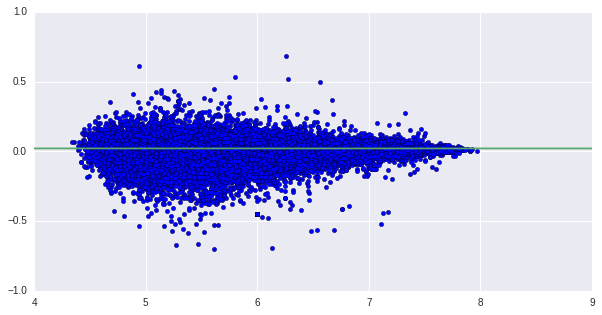

In [6]:
plotRI(exp,"C57BL/6J_Liver_CD","BXD90_Liver_HFD")

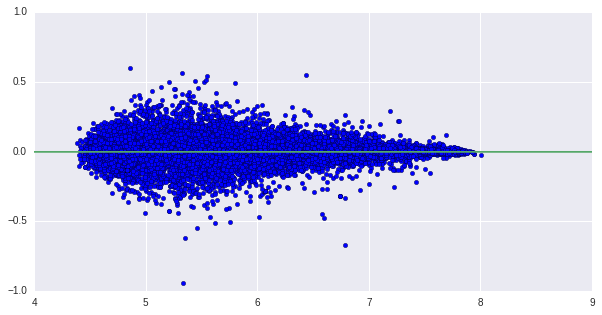

In [7]:
plotRI(exp,"BXD98_Liver_HFD","BXD101_Liver_HFD")

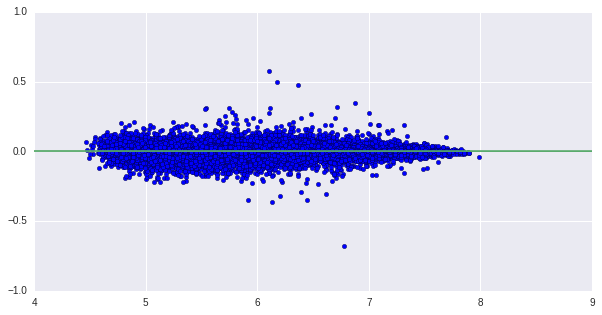

In [221]:
plotRI(exp,"BXD98_Liver_HFD","BXD96_Liver_HFD")

#### Subsubtask 1.3.3: Implement a rle plot (rle = relative log expression)

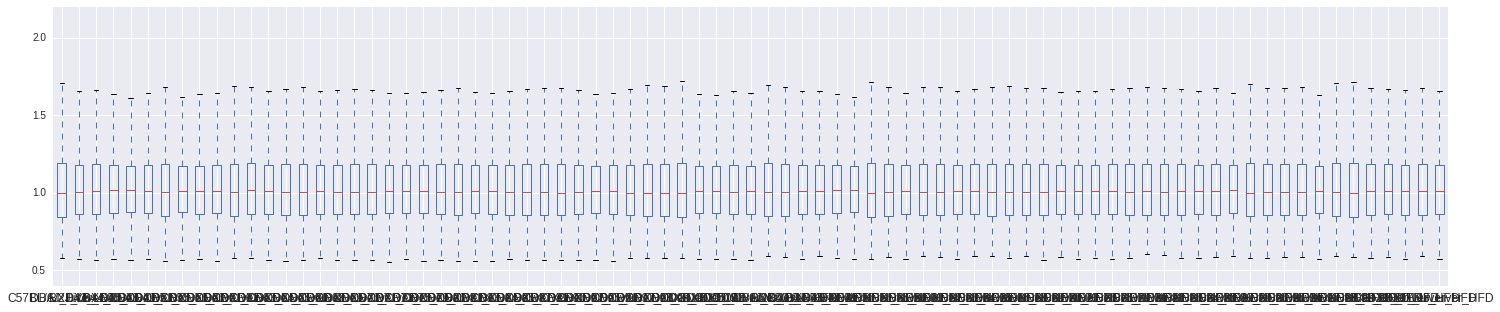

In [9]:
medians = []
rle = pd.DataFrame()
i = 0
fig,ax = plt.subplots(1,1,figsize=(25,5))
for gene in exp:
    if 'Liver' in gene:
        medians.append(exp[gene].median())
        rle[gene] = exp[gene] / medians[i]
rle.boxplot(return_type = 'axes')

#### Subsubtask 1.3.4: Apply your RLE plot to the data

In [11]:
exp.loc('')

#### Subsubtask 1.3.5: If you consider it necessary, perform a quantile normalization of the data 

## Task 2: Which statistical test to chose?

We want to infer differentially expressed genes between the CD and the HFD condition. Therefore we (mis)(?)treat (!) the (already) normalized expression values of all the strains for a given condition as independent observations of the same sample. But first we need to figure out which statistical test for differential expression seems appropriate (concerning distribution and variance assumptions) and then apply it. Limit yourself to the Student t-test, the Welch t-test or Wilcoxon's rank-sum test (also sometimes refered to as Whitney-Mann U-test).

Everything you may need, is most likely found here:

http://docs.scipy.org/doc/scipy-0.17.1/reference/stats.html 

http://statsmodels.sourceforge.net/stable/graphics.html

### Subtask 2.1: Do the CD and HFD samples have equal variance?

Josef-Francisco Del-Marre-Doyle, famous and visionary president of the International BXD Society (IBXDS), just gave a celebrated TED-talk in which he reviewed the fact that any statistic associated with the universe is almost surely normally distributed, and hence you canonically assume that the only thing left to check is whether the samples have equal variance, that is whether to apply Student's or Welch's t-test. Josef-Francisco's assessment usually is that "things are equal" and so you're quite confident that you'll be able to use Student's t-test. But since you're an excellent scientist (and, additionally, won't pass the course otherwise) you still do the following certainly unnecessary work:

#### Subsubtask 2.1.1: Choose a random row of your latest dataframe using the random module of Python

In [12]:
import random
random = random.randint(0,21834)

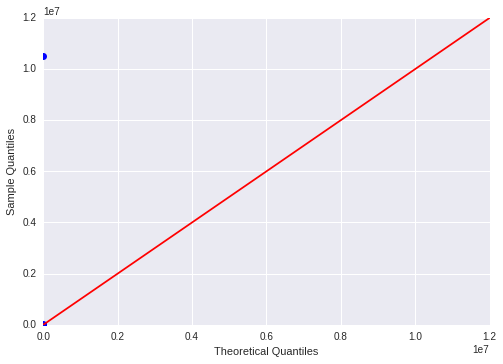

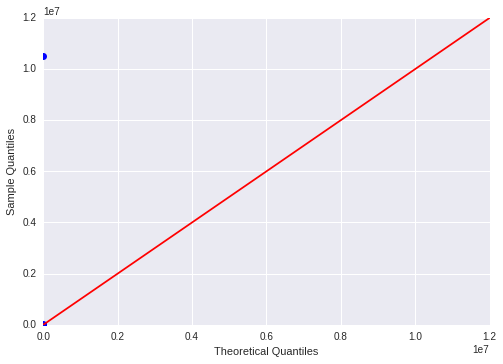

In [13]:
sm.graphics.qqplot(exp.ix[random], line='45')

#### Subsubtask 2.1.2: Make a Q-Q plot comparing the two samples for the just chosen gene and answer the question: Does this tell you anything?

In [14]:
exp_CD

NameError: name 'exp_CD' is not defined

In [ ]:
exp_CD.columns

#### Subsubtask 2.1.3: Apply an appropriate statistical test in order to figure out whether the samples have equal variance (there may be more than one sensible solution)

In [16]:
cols = [c for c in exp.columns if c.upper()[-3:] != 'HFD']

In [17]:
exp_CD = exp[cols]

In [18]:
exp_CD.head()

,Original_Order,MATCH_ORDER,Probeset,Range CD,Range_All,C57BL/6J_Liver_CD,DBA/2J_Liver_CD,BXD43_Liver_CD,BXD44_Liver_CD,BXD45_Liver_CD,...,BXD90_Liver_CD,BXD92_Liver_CD,BXD95_Liver_CD,BXD96_Liver_CD,BXD97_Liver_CD,BXD98_Liver_CD,BXD99_Liver_CD,BXD100_Liver_CD,BXD101_Liver_CD,BXD103_Liver_CD
Gene,,,,,,,,,,,,,,,,,,,,,
39872,31277.0,NaN,10572050.0,2.297397,2.297397,7.864,7.180,7.067,7.265,7.427,...,7.016,7.397,7.210,7.486,7.327,7.269,7.151,7.322,7.365,7.415
39873,17826.0,NaN,10450025.0,1.458009,1.611049,10.778,10.730,10.931,10.736,10.749,...,10.780,10.992,10.709,10.967,10.788,10.953,10.666,10.991,10.982,10.660
39874,18766.0,NaN,10458983.0,1.542211,1.604362,7.527,7.754,7.533,7.659,7.592,...,7.376,7.364,7.583,7.682,7.428,7.425,7.382,7.807,7.552,7.597
39875,7705.0,NaN,10355474.0,1.718322,1.772763,6.773,7.288,7.289,6.929,7.510,...,7.154,7.051,7.115,7.077,7.178,6.867,7.196,7.280,7.223,7.438
39876,19195.0,NaN,10462791.0,1.593280,1.854461,11.095,11.272,11.690,11.564,11.566,...,11.469,11.518,11.330,11.401,11.692,11.473,11.487,11.460,11.395,11.430


In [19]:
cols = [c for c in exp.columns if c.upper()[-3:] != '_CD']

In [20]:
exp_HFD = exp[cols]

In [21]:
cols = [c for c in exp.columns if c.upper()[-3:] == '_CD']

In [22]:
exp_CD = exp_CD[cols]

In [23]:
cols = [c for c in exp.columns if c.upper()[-4:] == '_HFD']

In [24]:
exp_HFD = exp_HFD[cols]

In [25]:
exp_CD = exp_CD.drop("BXD92_Liver_CD",axis=1)

In [26]:
exp_CD.head()

,C57BL/6J_Liver_CD,DBA/2J_Liver_CD,BXD43_Liver_CD,BXD44_Liver_CD,BXD45_Liver_CD,BXD48_Liver_CD,BXD49_Liver_CD,BXD51_Liver_CD,BXD55_Liver_CD,BXD56_Liver_CD,...,BXD89_Liver_CD,BXD90_Liver_CD,BXD95_Liver_CD,BXD96_Liver_CD,BXD97_Liver_CD,BXD98_Liver_CD,BXD99_Liver_CD,BXD100_Liver_CD,BXD101_Liver_CD,BXD103_Liver_CD
Gene,,,,,,,,,,,,,,,,,,,,,
39872,7.864,7.180,7.067,7.265,7.427,7.410,7.411,7.606,7.137,7.507,...,7.117,7.016,7.210,7.486,7.327,7.269,7.151,7.322,7.365,7.415
39873,10.778,10.730,10.931,10.736,10.749,10.957,10.871,10.638,10.876,10.649,...,10.930,10.780,10.709,10.967,10.788,10.953,10.666,10.991,10.982,10.660
39874,7.527,7.754,7.533,7.659,7.592,7.244,7.377,7.598,7.412,7.605,...,7.480,7.376,7.583,7.682,7.428,7.425,7.382,7.807,7.552,7.597
39875,6.773,7.288,7.289,6.929,7.510,7.128,7.181,7.507,7.062,7.048,...,7.206,7.154,7.115,7.077,7.178,6.867,7.196,7.280,7.223,7.438
39876,11.095,11.272,11.690,11.564,11.566,11.734,11.514,11.380,11.482,11.457,...,11.317,11.469,11.330,11.401,11.692,11.473,11.487,11.460,11.395,11.430


In [27]:
exp_HFD.head()

,C57BL/6J_Liver_HFD,DBA/2J_Liver_HFD,BXD43_Liver_HFD,BXD44_Liver_HFD,BXD45_Liver_HFD,BXD48_Liver_HFD,BXD49_Liver_HFD,BXD50_Liver_HFD,BXD51_Liver_HFD,BXD55_Liver_HFD,...,BXD89_Liver_HFD,BXD90_Liver_HFD,BXD95_Liver_HFD,BXD96_Liver_HFD,BXD97_Liver_HFD,BXD98_Liver_HFD,BXD99_Liver_HFD,BXD100_Liver_HFD,BXD101_Liver_HFD,BXD103_Liver_HFD
Gene,,,,,,,,,,,,,,,,,,,,,
39872,7.604,7.705,7.602,7.670,7.961,7.758,7.880,7.522,7.796,7.805,...,7.538,7.707,7.491,7.923,7.601,7.780,7.597,7.679,7.666,7.725
39873,11.151,10.693,11.012,10.795,11.101,11.045,10.798,10.644,10.847,11.003,...,11.015,10.983,10.982,11.153,11.189,11.026,11.054,11.064,11.006,10.808
39874,7.494,7.405,7.613,7.398,7.217,7.459,7.484,7.196,7.276,7.359,...,7.581,7.488,7.554,7.461,7.592,7.425,7.410,7.539,7.388,7.334
39875,7.061,7.285,7.134,7.251,6.909,7.406,6.871,6.940,7.306,7.109,...,7.307,7.333,7.555,7.098,7.101,7.091,7.246,7.021,7.246,7.339
39876,11.022,10.843,11.407,11.354,11.294,11.153,11.422,11.548,11.321,11.362,...,11.360,11.447,11.450,11.136,11.382,11.390,11.561,11.031,11.189,11.204


In [28]:
exp_CD_random = exp_CD.ix[random]

In [29]:
exp_HFD_random = exp_HFD.ix[random]

In [30]:
sp.bartlett(exp_CD_random,exp_HFD_random)

BartlettResult(statistic=0.0053455092294834227, pvalue=0.94171620521995336)

#### Subsubtask 2.1.4: To asses the global situation, plot a histogram of p-values for all the genes (using the same test you chose in 2.1.3)

In [31]:
bartlett = pd.DataFrame()
for row in xrange(0,21834):
    result =  sp.bartlett(exp_CD.ix[row],exp_HFD.ix[row])
    bartlett.loc[row,'pvalue'] = result[1]

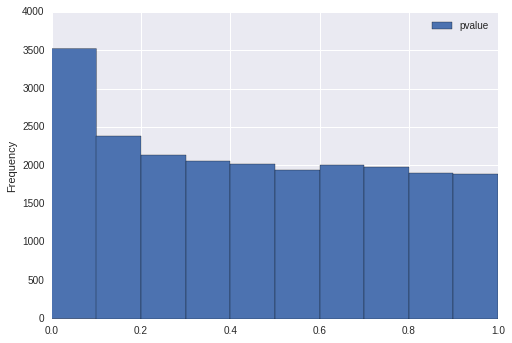

In [32]:
bartlett.plot.hist()

### Subtask 2.2 Are the CD and HFD samples normally distributed?

Utterly shocked and overwhelmed by ambiguous emotions you begin to doubt the wisdom of Josef-Francisco and start a top-secret and highly dangerous investigation whether the samples are at least normally distributed. Be careful whom you'll tell about that you're working on this...

#### Subsubtask 2.2.1: Using the same gene randomly chosen above, make a Box plot for the corresponding CD and HFD sample and give an interpretation

In [33]:
random_gene_CD = pd.DataFrame(exp_CD.ix[random])

In [34]:
random_gene_HFD = pd.DataFrame(exp_HFD.ix[random])

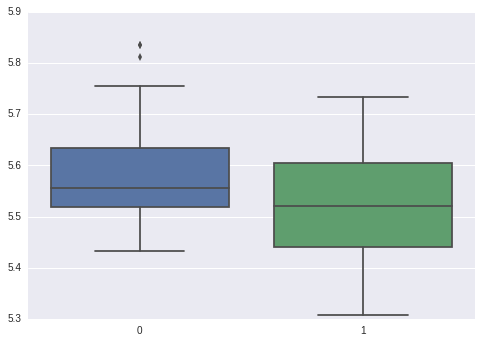

In [35]:
sns.boxplot(data=[random_gene_CD,random_gene_HFD])

#### Subsubtask 2.2.2: Just like in 2.2.1 make Q-Q plots for each sample (compare each to the theoretical normal distribution) and try an interpretation.

In [36]:
sp.stats.zscore

<function scipy.stats.stats.zscore>

In [37]:
sp.stats.zscore(random_gene_CD, axis=0, ddof=0)

array([[-0.95516519],
       [ 2.36840506],
       [ 0.0852568 ],
       [ 1.308716  ],
       [ 2.14683371],
       [ 0.68253609],
       [ 0.96190867],
       [-0.5409231 ],
       [-0.34825236],
       [-0.66615908],
       [-0.45422127],
       [-0.82029567],
       [ 0.00818851],
       [-0.07851333],
       [-1.2441713 ],
       [ 0.12379095],
       [-0.73359384],
       [-0.04961272],
       [ 1.60735564],
       [ 0.7114367 ],
       [ 1.58808857],
       [-0.87809689],
       [ 0.91374098],
       [ 2.36840506],
       [-0.48312188],
       [-1.51391033],
       [-1.34050667],
       [-0.40605358],
       [-0.2808176 ],
       [-0.76249445],
       [ 0.22012632],
       [ 0.23939339],
       [-1.30197252],
       [ 0.17195863],
       [ 0.3453623 ],
       [-0.50238895],
       [-0.42532066],
       [-0.53128956],
       [-0.9840658 ],
       [-0.55055664]])

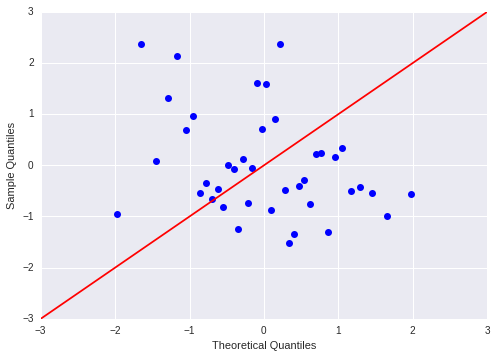

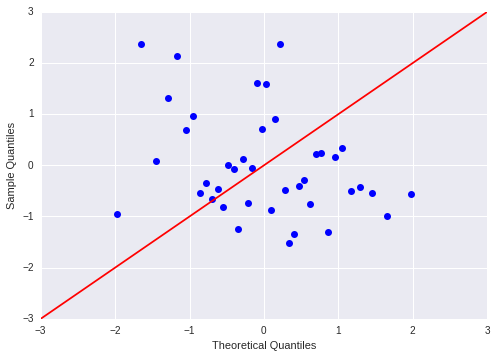

In [38]:
sm.graphics.qqplot(sp.stats.zscore(random_gene_CD, axis=0, ddof=0), line='45')

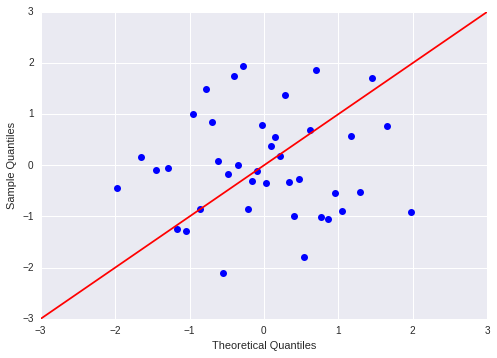

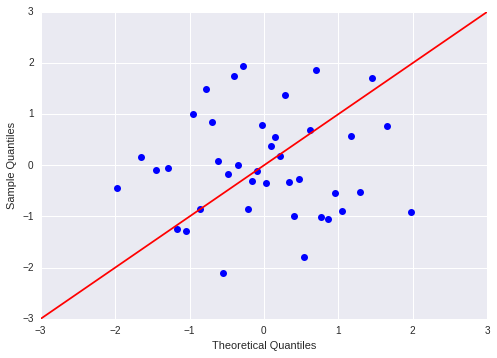

In [39]:
sm.graphics.qqplot(sp.stats.zscore(random_gene_HFD, axis=0, ddof=0), line='45')

#### Subsubtask 2.2.3: Apply an appropriate statistical test in order to figure out whether the samples are normally distributed (there may be more than one sensible solution)

In [44]:
sp.stats.mstats_basic.normaltest

<function scipy.stats.mstats_basic.normaltest>

In [45]:
_,pvalues_norm_HFD = sp.stats.mstats_basic.normaltest(exp_HFD.T)

In [46]:
_,pvalues_norm_CD = sp.stats.mstats_basic.normaltest(exp_CD.T)

In [48]:
pvalues_norm = pd.DataFrame(pvalues_norm_CD[1])

PandasError: DataFrame constructor not properly called!

array([ 0.32241816,  0.3602344 ,  0.82369018, ...,  0.04005298,
        0.61290584,  0.04595264])

#### Subsubtask 2.2.4: To asses the global situation, plot a histogram of p-values for all the genes (using the same test you chose in 2.2.3)

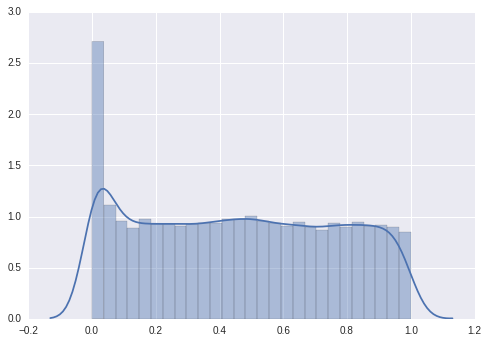

In [49]:
sns.distplot(pvalues_norm_HFD)

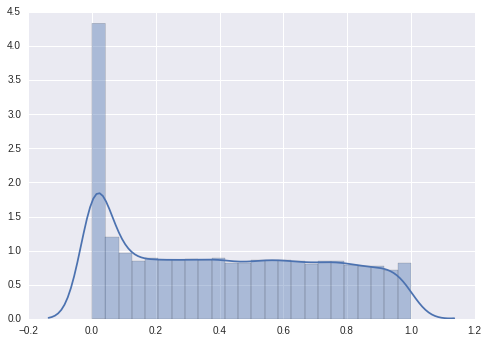

In [50]:
sns.distplot(pvalues_norm_CD)

In [53]:
p_values_norm = pd.DataFrame()
for row in xrange(1,21834):
    result =  sp.bartlett(exp_CD.ix[row],exp_HFD.ix[row])
    bartlett.loc[row,'pvalue'] = result[1]

#### Subsubtask 2.2.5: Write a 1-word essay about whether there is any instrinsic philosophical reason that any data follows a normal distribution

No

### Subtask 2.3 Choose a suitable statistical test to assess differential expression, apply it to every row, store the results in a suitable dataframe (you may want to order the genes with respect to their p-values) and finally extract a list of differentially expressed genes (5% significance). How many differentially expressed genes do you get?

In [54]:
sp.stats.mannwhitneyu(exp_CD["BXD44_Liver_CD"], exp_HFD["BXD44_Liver_HFD"], use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=235969359.0, pvalue=0.034655684354446652)

In [55]:
def diffExp(df1,df2):
    """
    This Method checks if a gene is differentially expressed given two dataframes from 2 different strains
    containing expression values for each gene
    @param df1: first dataframe
    @param df2: second dataframe
    """
    
    exp_total = exp_HFD.join(exp_CD)
    pvalues_ttest = pd.DataFrame()
    pvalues = []
    for row in xrange(0,21834):
        #_, pvalue_ttest = sp.ttest_1samp(exp_total.ix[row],exp_total.ix[].mean()
        _, pvalue = sp.stats.mannwhitneyu(exp_CD.ix[row], exp_HFD.ix[row], use_continuity=False)
        #rowname = str(exp_total.T.columns[row])
        #pvalues_ttest[rowname] = pvalue
        pvalues.append(pvalue)
    pvalues_df = pd.DataFrame(pvalues)
    pvalues_df.index = exp.index
    pvalues_df.columns = ['p_values']
    return pvalues_df

In [153]:
pvalues = diffExp(exp_CD,exp_HFD)

In [154]:
pvalues = pvalues.sort_values(by = 'p_values')

## Task 3: Multiple-testing correction

You receive an anonymous letter revealing to you that you should do multiple-testing correction, otherwise something awfully bad will happen, or not. Puzzled and shaking you embark on this endeavour.

Fredholm, your lab's vodoo priest, is convinced that applying anything else than Bonferroni correction brings death and destruction to the people on the moon. Opportunistically neglecting any potential societal consequences of your actions (technology is neutral after all and who cares about the moon anyway!) you're obsessed to try as many multiple testing procedures as possible.

Everything you may need, is most likely found here:

http://statsmodels.sourceforge.net/stable/stats.html#multiple-tests-and-multiple-comparison-procedures

### Subtask 3.1: For your official report you have to pretend to care about Bonferroni's correction (otherwise it will never pass through Fredholm's office): manually code it (do not use the statsmodels implementation for example) and store the results in a suitable dataframe. How many differentially expressed gene do you get?

In [184]:
def multipleTesting(pvalues_,method):
    if method != 'bonferroni':
        pvalues_corrected = sm.stats.multipletests(pvalues_['p_values'],method=method)
        pvalues_corrected = pd.DataFrame(pvalues_corrected[1])
    else:
        pvalues_corrected = pvalues_["p_values"] * len(pvalues_)
        pvalues_corrected = pd.DataFrame(pvalues_corrected)
    pvalues_corrected.index = pvalues_.index
    pvalues_corrected.columns = [method]
    pvalues_corrected = pvalues_corrected.sort_values(by=method)
    return pvalues_corrected

In [185]:
pvalues_filtered = pvalues[pvalues.p_values < 0.05]

### Subtask 3.2: Apply all multiple testing procedures you can get your hands on (except Bonferroni; now you should use statsmodels) to your uncorrected p-values and store the results in one (!) dataframe. 

In [194]:
pvalues_corrected = multipleTesting(pvalues_filtered,"bonferroni")

In [195]:
pvalues_corrected['sidak'] = multipleTesting(pvalues_filtered,"sidak")
pvalues_corrected['holm-sidak'] = multipleTesting(pvalues_filtered,"holm-sidak")
pvalues_corrected['simes-hochberg'] = multipleTesting(pvalues_filtered,"simes-hochberg")
pvalues_corrected['hommel'] = multipleTesting(pvalues_filtered,"hommel")
pvalues_corrected['fdr_tsbky'] = multipleTesting(pvalues_filtered,"fdr_tsbky")

In [202]:
#pvalues_corrected

### Subtask 3.3: External visual comparison of the different methods
1 Write the DE dataframe to a csv file.
2 add a row with either 'numeric' or 'factor' as the first row to describe the data schema and save the file
3 use [paco](http://parallelcoordinates.de/paco) to visualize your data in parallel coordinates
4 which of the multiple testing methods is the most stringent? What's the relation between the others?

In [197]:
pvalues_corrected.dropna(inplace = True) 

In [201]:
#pvalues_corrected[pvalues_corrected.sidak < 0.05]

In [192]:
pvalues_corrected.to_csv("../IOFolder/pvalues_corrected.csv")

Bonferroni is the most stringent, the other methods imply more or less the same amount of differentially expressed genes

### Subtask 3.4: Select a random method applied in 3.2 and extract the corresponding list of differentially expressed genes. Is this list contain more or less genes than the list from 2.3? Does it contain more or less genes than your Bonferroni list? ;)

As a comparison I chose the list with the sidak corrected p values.The list contains 8000 less elements than the list from 2.3 and 30 genes more than the bonferroni list.  

## Task 4: Vulcano plots

Marie de la Stratonovich, the devious intellectual opponent of your (former) beloved idol Josef-Francisco Del-Marre-Doyle just received the glorious Popel prize (the first marsian scientist ever to reveive that prize) for copy-pasting the content of the following papers:

1) arXiv:1103.3434 (https://arxiv.org/abs/1103.3434)

2) http://www.ncbi.nlm.nih.gov/pubmed/23602812 (doi:10.1016/j.compbiolchem.2013.02.003)

Overwhelmed by these achievments (and motivated by your ever declining esteem for Josef-Francisco) your're immensely excited about the joyous prospect of carrying out out the following tasks:

### Subtask 4.1: Add a log2 fold change column to the data frame from 3.2 and store it as a csv file.

In [203]:
pvalues_corrected

,bonferroni,sidak,holm-sidak,simes-hochberg,hommel,fdr_tsbky
Gene,,,,,,
Hus1b,9.265555e-11,9.255396e-11,9.255396e-11,9.265555e-11,9.193889e-11,7.489817e-14
5330416C01Rik,9.272099e-11,9.255396e-11,9.255396e-11,9.270720e-11,9.200383e-11,7.489817e-14
Glra4,9.272099e-11,9.255396e-11,9.255396e-11,9.270720e-11,9.200383e-11,7.489817e-14
Caprin2,9.281923e-11,9.255396e-11,9.255396e-11,9.279852e-11,9.210131e-11,7.489817e-14
D630002G06Rik,9.285200e-11,9.255396e-11,9.255396e-11,9.281057e-11,9.212692e-11,7.489817e-14
6330409D20Rik,9.285200e-11,9.255396e-11,9.255396e-11,9.281057e-11,9.212692e-11,7.489817e-14
Olfr202,9.285200e-11,9.255396e-11,9.255396e-11,9.281057e-11,9.212692e-11,7.489817e-14
Olfr812,9.993175e-11,1.000180e-10,9.996592e-11,9.987972e-11,9.912165e-11,7.489817e-14
Thnsl1,1.001431e-10,1.000180e-10,9.996592e-11,1.000835e-10,9.933129e-11,7.489817e-14


### Subtask 4.2:  Implement a Vulcano plot (from scratch using matplotlib)

In [210]:
exp_CD.head()

,C57BL/6J_Liver_CD,DBA/2J_Liver_CD,BXD43_Liver_CD,BXD44_Liver_CD,BXD45_Liver_CD,BXD48_Liver_CD,BXD49_Liver_CD,BXD51_Liver_CD,BXD55_Liver_CD,BXD56_Liver_CD,...,BXD89_Liver_CD,BXD90_Liver_CD,BXD95_Liver_CD,BXD96_Liver_CD,BXD97_Liver_CD,BXD98_Liver_CD,BXD99_Liver_CD,BXD100_Liver_CD,BXD101_Liver_CD,BXD103_Liver_CD
Gene,,,,,,,,,,,,,,,,,,,,,
39872,7.864,7.180,7.067,7.265,7.427,7.410,7.411,7.606,7.137,7.507,...,7.117,7.016,7.210,7.486,7.327,7.269,7.151,7.322,7.365,7.415
39873,10.778,10.730,10.931,10.736,10.749,10.957,10.871,10.638,10.876,10.649,...,10.930,10.780,10.709,10.967,10.788,10.953,10.666,10.991,10.982,10.660
39874,7.527,7.754,7.533,7.659,7.592,7.244,7.377,7.598,7.412,7.605,...,7.480,7.376,7.583,7.682,7.428,7.425,7.382,7.807,7.552,7.597
39875,6.773,7.288,7.289,6.929,7.510,7.128,7.181,7.507,7.062,7.048,...,7.206,7.154,7.115,7.077,7.178,6.867,7.196,7.280,7.223,7.438
39876,11.095,11.272,11.690,11.564,11.566,11.734,11.514,11.380,11.482,11.457,...,11.317,11.469,11.330,11.401,11.692,11.473,11.487,11.460,11.395,11.430


### Subtask 4.3: Apply your Volcano plot implementation to the uncorrected p-values, as well as the corrected p-values from 3.4 (you should have two plots in the end ;))

In [211]:
exp_HFD.head()

,C57BL/6J_Liver_HFD,DBA/2J_Liver_HFD,BXD43_Liver_HFD,BXD44_Liver_HFD,BXD45_Liver_HFD,BXD48_Liver_HFD,BXD49_Liver_HFD,BXD50_Liver_HFD,BXD51_Liver_HFD,BXD55_Liver_HFD,...,BXD89_Liver_HFD,BXD90_Liver_HFD,BXD95_Liver_HFD,BXD96_Liver_HFD,BXD97_Liver_HFD,BXD98_Liver_HFD,BXD99_Liver_HFD,BXD100_Liver_HFD,BXD101_Liver_HFD,BXD103_Liver_HFD
Gene,,,,,,,,,,,,,,,,,,,,,
39872,7.604,7.705,7.602,7.670,7.961,7.758,7.880,7.522,7.796,7.805,...,7.538,7.707,7.491,7.923,7.601,7.780,7.597,7.679,7.666,7.725
39873,11.151,10.693,11.012,10.795,11.101,11.045,10.798,10.644,10.847,11.003,...,11.015,10.983,10.982,11.153,11.189,11.026,11.054,11.064,11.006,10.808
39874,7.494,7.405,7.613,7.398,7.217,7.459,7.484,7.196,7.276,7.359,...,7.581,7.488,7.554,7.461,7.592,7.425,7.410,7.539,7.388,7.334
39875,7.061,7.285,7.134,7.251,6.909,7.406,6.871,6.940,7.306,7.109,...,7.307,7.333,7.555,7.098,7.101,7.091,7.246,7.021,7.246,7.339
39876,11.022,10.843,11.407,11.354,11.294,11.153,11.422,11.548,11.321,11.362,...,11.360,11.447,11.450,11.136,11.382,11.390,11.561,11.031,11.189,11.204


In [219]:
fold_change = pd.DataFrame(exp_CD.T.mean() / exp_HFD.T.mean())

In [224]:
log_fold_change = np.log2(fold_change)

In [227]:
pvalues = pvalues.join(log_fold_change)

In [229]:
pvalues.columns = ['p_values', 'log2_fold_change']

In [231]:
volcano = pvalues

In [232]:
volcano['p_values'] = -1*np.log10(volcano['p_values'])

In [240]:
pvalues.columns = ['-log_p_values', 'log2_fold_change']

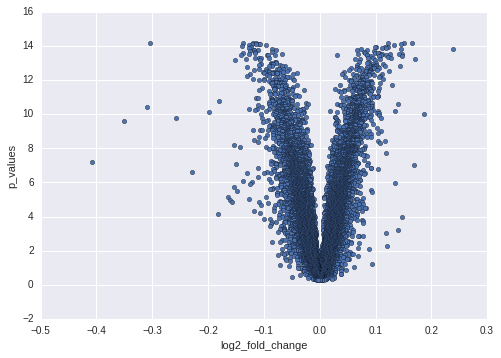

In [239]:
volcano.plot.scatter(x='log2_fold_change',y='-log_p_values')

## Task 5: RNA-seq

There are faint rumours that some supposedly revolutionary technology could also be used to study gene expression. Find out the name of that technology and outline the most striking difference of that technology compared to microarrays from a statistical modeling point of view.